In [2]:
#import libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sna
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#read the data from CSV
data = pd.read_csv('OnlineRetail.csv',encoding = "ISO-8859-1")

In [4]:
data.head(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom


In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [6]:
data['InvoiceDate'].describe()

C:\Users\Karthika Preethi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [7]:
nl = data.query("Country=='Netherlands'").reset_index(drop=True)

In [8]:
user = pd.DataFrame(data['CustomerID'].unique())
user.columns = ['CustomerID']

### Recency

In [9]:
max_purchase = nl.groupby('CustomerID').InvoiceDate.max().reset_index()

In [10]:
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [11]:
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

In [12]:
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')

In [13]:
user.head()

,CustomerID,Recency
0,12791.0,372
1,14646.0,0
2,12778.0,18
3,12775.0,15
4,12759.0,50


In [14]:
user.Recency.describe()

count      9.000000
mean      99.777778
std      125.044770
min        0.000000
25%       15.000000
50%       50.000000
75%      182.000000
max      372.000000
Name: Recency, dtype: float64

In [15]:
plot_data = [
    go.Histogram(
        x=user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

C:\Users\Karthika Preethi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



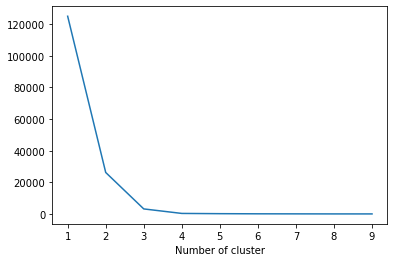

In [16]:
from sklearn.cluster import KMeans
sse={}
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [17]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])



In [18]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1.0,372.00,NaN,372.0,372.00,372.0,372.00,372.0
1,2.0,56.50,9.192388,50.0,53.25,56.5,59.75,63.0
2,2.0,186.00,5.656854,182.0,184.00,186.0,188.00,190.0
3,4.0,10.25,8.015610,0.0,6.00,11.5,15.75,18.0


In [19]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [20]:
user = order_cluster('RecencyCluster', 'Recency',user,False)

### Frequency

In [21]:
frequency = nl.groupby('CustomerID').InvoiceDate.count().reset_index()

In [22]:
frequency.columns = ['CustomerID', 'Frequency']

In [23]:
frequency.head()

,CustomerID,Frequency
0,12759.0,95
1,12775.0,67
2,12778.0,51
3,12787.0,20
4,12789.0,4


In [24]:
user = pd.merge(user, frequency, on='CustomerID')

In [25]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,12791.0,372,0,2
1,14646.0,0,3,2085
2,12778.0,18,3,51
3,12775.0,15,3,67
4,12787.0,8,3,20


In [26]:
user.Frequency.describe()

count       9.000000
mean      263.444444
std       683.762589
min         2.000000
25%        20.000000
50%        26.000000
75%        67.000000
max      2085.000000
Name: Frequency, dtype: float64

In [27]:
plot_data = [
    go.Histogram(
    x=user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
    title='Frequency'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

C:\Users\Karthika Preethi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Karthika Preethi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Karthika Preethi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

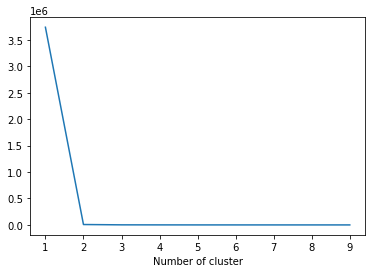

In [30]:
sse = {}
frequency = user[['Frequency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

In [32]:
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,5.0,14.6,10.853571,2.0,4.0,20.0,21.0,26.0
1,1.0,2085.0,NaN,2085.0,2085.0,2085.0,2085.0,2085.0
2,2.0,59.0,11.313708,51.0,55.0,59.0,63.0,67.0
3,1.0,95.0,NaN,95.0,95.0,95.0,95.0,95.0


In [33]:
user = order_cluster('FrequencyCluster', 'Frequency',user,True)

### Monetary Value

In [35]:
nl['Revenue']= nl['UnitPrice'] * nl['Quantity']

In [36]:
revenue = nl.groupby('CustomerID').Revenue.sum().reset_index()

In [37]:
revenue.head()

,CustomerID,Revenue
0,12759.0,1531.44
1,12775.0,1351.24
2,12778.0,804.23
3,12787.0,463.66
4,12789.0,91.85


In [38]:
user = pd.merge(user, revenue, on='CustomerID')

In [39]:
user.Revenue.describe()

count         9.00000
mean      31629.06000
std       92948.83648
min          91.85000
25%         324.92000
50%         463.66000
75%        1351.24000
max      279489.02000
Name: Revenue, dtype: float64

In [41]:
plot_data = [
    go.Histogram(
        x=user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [42]:
import warnings
warnings.filterwarnings("ignore")

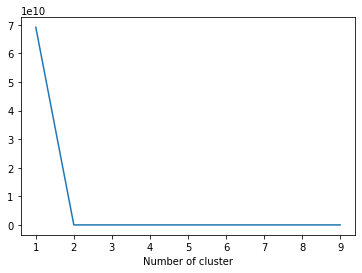

In [43]:
sse={}
revenue = user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [44]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])

In [45]:
user = order_cluster('RevenueCluster', 'Revenue',user,True)

In [46]:
user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5.0,297.122,154.028915,91.85,192.60,324.92,412.58,463.66
1,1.0,804.230,NaN,804.23,804.23,804.23,804.23,804.23
2,2.0,1441.340,127.420642,1351.24,1396.29,1441.34,1486.39,1531.44
3,1.0,279489.020,NaN,279489.02,279489.02,279489.02,279489.02,279489.02


### Overall Segmentation

In [48]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12791.0,372,0,2,0,192.60,0
1,12787.0,8,3,20,0,463.66,0
2,12789.0,63,2,4,0,91.85,0
3,12790.0,190,1,21,0,324.92,0
4,12802.0,182,1,26,0,412.58,0


In [49]:
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']

In [51]:
user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,372.0,2.0,192.60
1,186.0,23.5,368.75
2,63.0,4.0,91.85
3,8.0,20.0,463.66
5,18.0,51.0,804.23
6,32.5,81.0,1441.34
9,0.0,2085.0,279489.02


In [52]:
user.groupby('OverallScore')['Recency'].count()

OverallScore
0    1
1    2
2    1
3    1
5    1
6    2
9    1
Name: Recency, dtype: int64

In [53]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value'